**Importing Essential Libraries**


In [0]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import zipfile
import cv2
import tensorflow as tf
import pickle

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D ,AveragePooling2D, Flatten, Dropout
from keras.layers.core import Dense
from keras.optimizers import RMSprop,Adam,SGD
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

sns.set()

**Unzipping the Train and Test sets**

In [55]:
os.getcwd()

'/content'

In [0]:
handle_train=zipfile.ZipFile(r'/content/Train.zip')
handle_train.extractall('/content/train')
handle_train.close()
handle_test=zipfile.ZipFile(r'/content/Test.zip')
handle_test.extractall('/content/test')
handle_test.close()

In [0]:
train_images=os.listdir('/content/train/Train/')
test_images = os.listdir('/content/test/Test')

filepath_train = '/content/train/Train/'
filepath_test = '/content/test/Test/' 

In [58]:
df_train = pd.read_csv('/content/train.csv')
df_train.head(10)

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE
5,6283.jpg,MIDDLE
6,23495.jpg,YOUNG
7,7100.jpg,YOUNG
8,6028.jpg,YOUNG
9,22617.jpg,OLD


In [59]:
sample_submn = pd.read_csv('/content/sample_submission_sDO3m7O.csv')
sample_submn.head()

,Class,ID
0,MIDDLE,25321.jpg
1,MIDDLE,989.jpg
2,MIDDLE,19277.jpg
3,MIDDLE,13093.jpg
4,MIDDLE,5367.jpg


**Reading & Resizing Training and Testing images**

In [0]:

images=[]
labels=[]

for index, row in df_train.iterrows():
  image=cv2.imread(filepath_train+row['ID'])
  image=cv2.resize(image , (64,64))
  images.append(image)
  labels.append(row['Class'])
  #print(row['ID'])


In [0]:
images_test=[]
outputs=[]

for index,row in sample_submn.iterrows():
  image=cv2.imread(filepath_test+row['ID'])
  image=cv2.resize(image , (64,64))
  images_test.append(image) 
  outputs.append(image)

**Displaying couple of images for Sanity check**

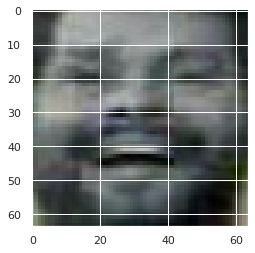

In [62]:
plt.imshow(images[0])

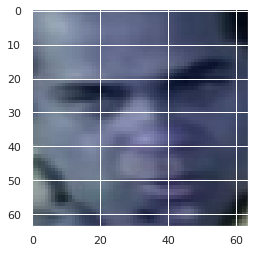

In [63]:
plt.imshow(images[19905])

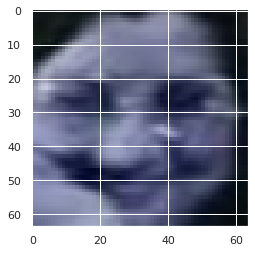

In [64]:
plt.imshow(outputs[0])

Converting into an n-d array and normalizing the image pixels

In [0]:
images = np.array(images, dtype="float") / 255.0
images_test = np.array(images_test, dtype="float") / 255.0
labels = np.array(labels)

**Splitting into train and test set for training**

In [0]:
(trainX, testX, trainY, testY) = train_test_split(images,labels, test_size=0.20, random_state=42)

In [67]:
print(type(trainX))
print(trainX.shape)
print(type(trainY))
print(trainY.shape)
print(type(testX))
print(testX.shape)
print(type(testY))
print(testY.shape)

<class 'numpy.ndarray'>
(15924, 64, 64, 3)
<class 'numpy.ndarray'>
(15924,)
<class 'numpy.ndarray'>
(3982, 64, 64, 3)
<class 'numpy.ndarray'>
(3982,)


Binarizing the output categories 

In [0]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [69]:
lb.classes_

array(['MIDDLE', 'OLD', 'YOUNG'], dtype='<U6')

In [70]:
trainY

array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0]])

In [0]:
class myCB(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs.get('val_accuracy')>0.88):
      print('\nReached least val_loss')
      self.model.stop_training = True


In [0]:
cb = myCB()

**Model Implementation**

In [0]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = "same", activation ='relu', input_shape = (64,64,3)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,kernel_size=(3,3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(84, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(3,activation="softmax"))


In [74]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)       

In [0]:
INIT_LR = 0.025
EPOCHS = 125
BS = 64

opt=SGD(lr=INIT_LR)

model.compile(loss="categorical_crossentropy", optimizer=opt,	metrics=["accuracy"])

**Image Data Augmentation**

In [0]:
aug = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.2, zoom_range=0.1,horizontal_flip=True, fill_mode="nearest")

**Fitting the model onto the training set**

In [77]:
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),validation_data=(testX, testY), 
                        steps_per_epoch=len(trainX) // BS,epochs=EPOCHS,callbacks=[cb])

Epoch 1/125
248/248 [==============================] - 22s 90ms/step - loss: 1.0389 - accuracy: 0.5395 - val_loss: 1.0545 - val_accuracy: 0.5188
Epoch 2/125
248/248 [==============================] - 21s 85ms/step - loss: 0.8146 - accuracy: 0.6339 - val_loss: 0.8955 - val_accuracy: 0.5758
Epoch 3/125
248/248 [==============================] - 21s 86ms/step - loss: 0.7880 - accuracy: 0.6470 - val_loss: 0.7505 - val_accuracy: 0.6640
Epoch 4/125
248/248 [==============================] - 21s 86ms/step - loss: 0.7613 - accuracy: 0.6636 - val_loss: 0.7194 - val_accuracy: 0.6826
Epoch 5/125
248/248 [==============================] - 21s 84ms/step - loss: 0.7478 - accuracy: 0.6680 - val_loss: 0.7293 - val_accuracy: 0.6733
Epoch 6/125
248/248 [==============================] - 21s 84ms/step - loss: 0.7274 - accuracy: 0.6801 - val_loss: 0.6725 - val_accuracy: 0.7019
Epoch 7/125
248/248 [==============================] - 21s 84ms/step - loss: 0.7142 - accuracy: 0.6895 - val_loss: 0.6660 - val_ac

In [78]:
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=lb.classes_))

              precision    recall  f1-score   support

      MIDDLE       0.87      0.94      0.91      2181
         OLD       0.84      0.76      0.80       471
       YOUNG       0.92      0.84      0.88      1330

    accuracy                           0.88      3982
   macro avg       0.88      0.85      0.86      3982
weighted avg       0.89      0.88      0.88      3982



**Loss-Accuracy Tradeoff graph**

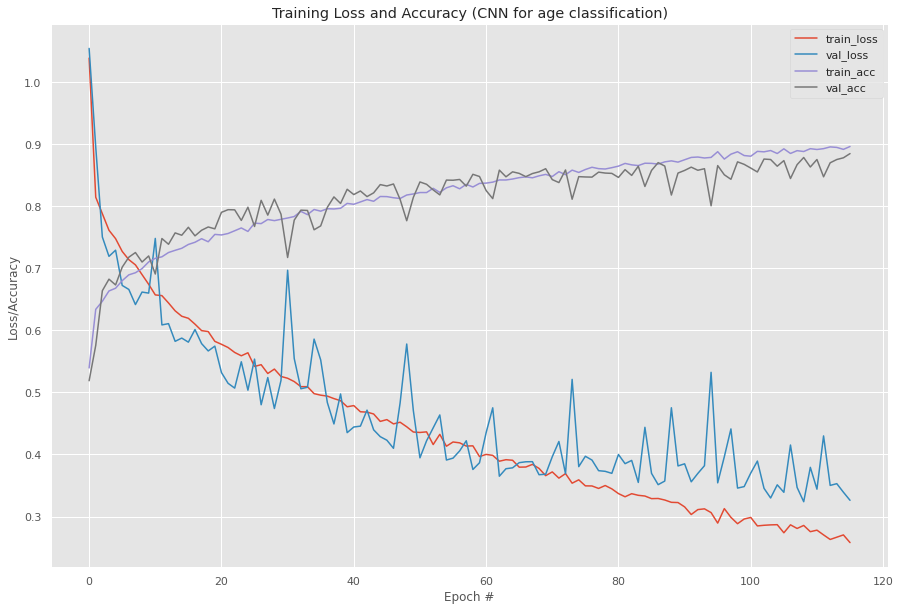

In [80]:
# plot the training loss and accuracy
N = np.arange(0, 116) #setting up x axis
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (CNN for age classification)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

**Predicting for test set values**

In [81]:
pred = model.predict(images_test)
pred

array([[7.3105776e-01, 2.4777535e-01, 2.1166919e-02],
       [2.3578739e-04, 1.8726847e-05, 9.9974543e-01],
       [4.4750997e-01, 1.0198932e-01, 4.5050073e-01],
       ...,
       [9.8885882e-01, 9.4509218e-03, 1.6902735e-03],
       [9.6010596e-01, 3.8208507e-02, 1.6855671e-03],
       [1.2868158e-02, 3.3779247e-03, 9.8375386e-01]], dtype=float32)

In [82]:
indexes = np.random.randint(0,6636,16)
indexes

array([5832, 1542, 4414, 3910, 1551, 5554,  273, 3317, 4674, 5459,  919,
       5543, 2471, 1738, 1589, 4751])

In [0]:
i_vals = []

for i in indexes:
  val = pred.argmax(axis=1)[i]
  i_vals.append(val)

In [84]:
i_vals

[0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 0, 2, 1, 0, 1, 1]

In [0]:
vals = []

for i in indexes:
  val = np.amax(pred , axis=1)[i]
  vals.append(val)

In [86]:
vals

[0.8902798,
 0.9986261,
 0.9255192,
 0.8373563,
 0.99970955,
 0.9864093,
 0.9628618,
 0.5639457,
 0.9714722,
 0.41314945,
 0.7306475,
 0.98275626,
 0.96545583,
 0.9829417,
 0.8920993,
 0.88332295]

In [87]:
vals = [i*100 for i in vals]
vals

[89.02798295021057,
 99.86261129379272,
 92.55192279815674,
 83.73563289642334,
 99.97095465660095,
 98.64093065261841,
 96.28617763519287,
 56.39457106590271,
 97.14722037315369,
 41.31494462490082,
 73.06475043296814,
 98.275625705719,
 96.54558300971985,
 98.29416871070862,
 89.20993208885193,
 88.33229541778564]

In [88]:
vals = [round(num,2) for num in vals]
vals

[89.03,
 99.86,
 92.55,
 83.74,
 99.97,
 98.64,
 96.29,
 56.39,
 97.15,
 41.31,
 73.06,
 98.28,
 96.55,
 98.29,
 89.21,
 88.33]

In [0]:
labels = []

for i in range(16):
  label = lb.classes_[i_vals[i]]
  labels.append(label)

In [90]:
labels

['MIDDLE',
 'MIDDLE',
 'MIDDLE',
 'MIDDLE',
 'MIDDLE',
 'MIDDLE',
 'YOUNG',
 'YOUNG',
 'YOUNG',
 'OLD',
 'MIDDLE',
 'YOUNG',
 'OLD',
 'MIDDLE',
 'OLD',
 'OLD']

In [0]:
from imutils import build_montages

In [0]:
results = []

for i in range(16):
  image = outputs[indexes[i]]

  text = labels[i] + " : " + str(vals[i])

  image = cv2.resize(image , (300,300))

  cv2.putText(image,text,(10,50),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),2)

  results.append(image)



In [0]:
from google.colab.patches import cv2_imshow

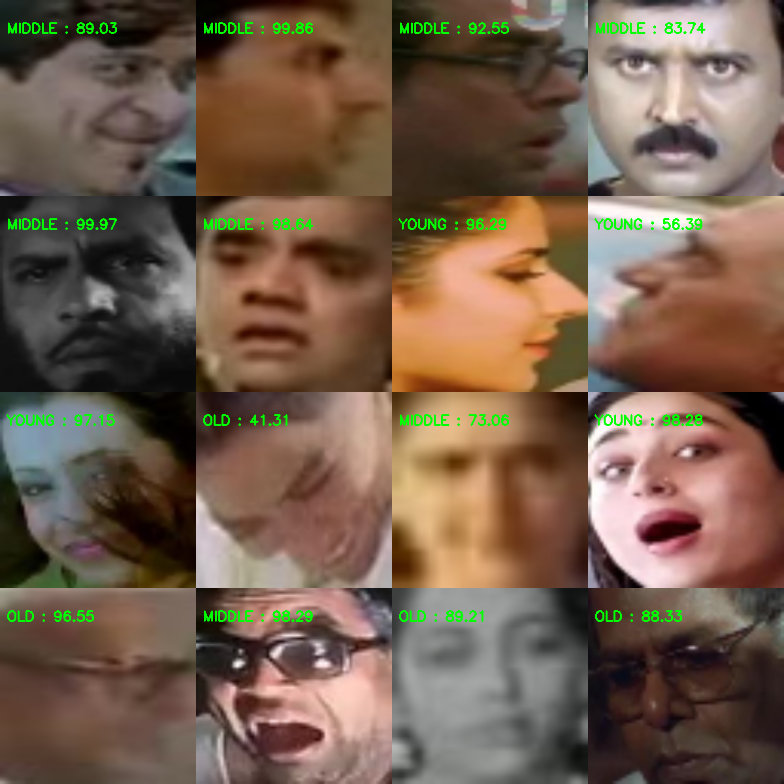

-1

In [94]:
montage = build_montages(results,(196,196),(4,4))[0]

cv2_imshow(montage)
cv2.waitKey(0)

**Displaying final image again after classification**

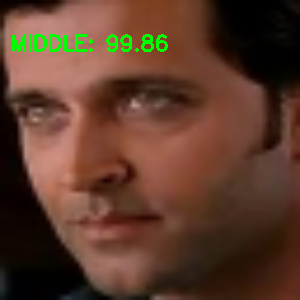

-1

In [95]:
text = labels[1]+": "+str(vals[1])

outputs[1] = cv2.resize(outputs[1] , (300,300))
cv2.putText(outputs[1], text , (10,50),  cv2.FONT_HERSHEY_SIMPLEX, 0.7 ,(0, 255, 0), 2)

# show the output image

cv2_imshow(outputs[1])
cv2.waitKey(0)

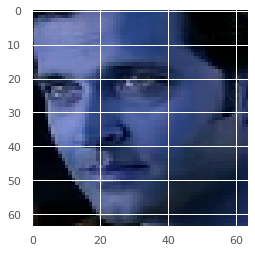

In [96]:
plt.imshow(images_test[1])

In [97]:
all_indexes = pred.argmax(axis=1)
all_indexes

array([0, 2, 2, ..., 0, 0, 2])

In [98]:
output_labels = lb.classes_[all_indexes]
output_labels

array(['MIDDLE', 'YOUNG', 'YOUNG', ..., 'MIDDLE', 'MIDDLE', 'YOUNG'],
      dtype='<U6')

In [99]:
submission = pd.DataFrame({'Class':output_labels,'ID':sample_submn['ID']})
submission

,Class,ID
0,MIDDLE,25321.jpg
1,YOUNG,989.jpg
2,YOUNG,19277.jpg
3,MIDDLE,13093.jpg
4,MIDDLE,5367.jpg
...,...,...
6631,MIDDLE,1876.jpg
6632,MIDDLE,14940.jpg
6633,MIDDLE,3638.jpg
6634,MIDDLE,376.jpg


In [0]:
submission.to_csv('submission_agenet2.csv',index=False)

In [0]:
from google.colab import files
files.download("submission_agenet2.csv")

**Exporting .h5 and .json files for Deployment in Flask**

In [0]:
#model_json = model.to_json()
#with open("model.json", "w") as json_file:
 #   json_file.write(model_json)

# serialize weights to HDF5
#model.save_weights("model.h5")

In [0]:
#from google.colab import files
#files.download("model.h5")

In [0]:
#from google.colab import files
#files.download("model.json")